In [12]:
from ingestion import make_cleaned, make_train_test
from metadata_helpers import save_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error


In [13]:
X_train, X_test, y_train, y_test = make_train_test()

categoric_cols = X_train.select_dtypes(include=object).columns.tolist()
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler())
OH_encoder = SklearnTransformerWrapper(transformer=OneHotEncoder(
    sparse_output=False, drop='if_binary', min_frequency=0.1, handle_unknown='ignore'), variables=categoric_cols)
pipe = make_pipeline(std_scaler, OH_encoder, ElasticNet(max_iter=2000))
gs = GridSearchCV(n_jobs=3, estimator=pipe, cv=10, scoring='neg_root_mean_squared_error', param_grid={
                  'elasticnet__l1_ratio': [0.7, 0.8, 0.9, 1.0], 'elasticnet__alpha': np.arange(0.6, 1.5, 0.1)})


In [14]:
gs.fit(X_train, y_train)


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 32] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sklearntransformerwrapper-1',
                                        SklearnTransformerWrapper(transformer=StandardScaler())),
                                       ('sklearntransformerwrapper-2',
                                        SklearnTransformerWrapper(transformer=OneHotEncoder(drop='if_binary',
                                                                                            handle_unknown='ignore',
                                                                                            min_frequency=0.1,
                                                                                            sparse_output=False),
                                                                  variables=['MSSubClass',
                                                                             'MSZoning',
                                                                             'Street',
                                                                             'Alley',
                                                                             'L...
                                                                             'BsmtExposure',
                                                                             'BsmtFinType1',
                                                                             'BsmtFinType2',
                                                                             'Heating',
                                                                             'CentralAir',
                                                                             'Electrical',
                                                                             'Functional',
                                                                             'GarageType',
                                                                             'GarageFinish',
                                                                             'PavedDrive', ...])),
                                       ('elasticnet',
                                        ElasticNet(max_iter=2000))]),
             n_jobs=3,
             param_grid={'elasticnet__alpha': array([0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4]),
                         'elasticnet__l1_ratio': [0.7, 0.8, 0.9, 1.0]},
             scoring='neg_root_mean_squared_error')

In [15]:
gs.param_grid


{'elasticnet__l1_ratio': [0.7, 0.8, 0.9, 1.0],
 'elasticnet__alpha': array([0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4])}

In [16]:
gs.best_params_


{'elasticnet__alpha': 0.9999999999999999, 'elasticnet__l1_ratio': 0.9}

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/en

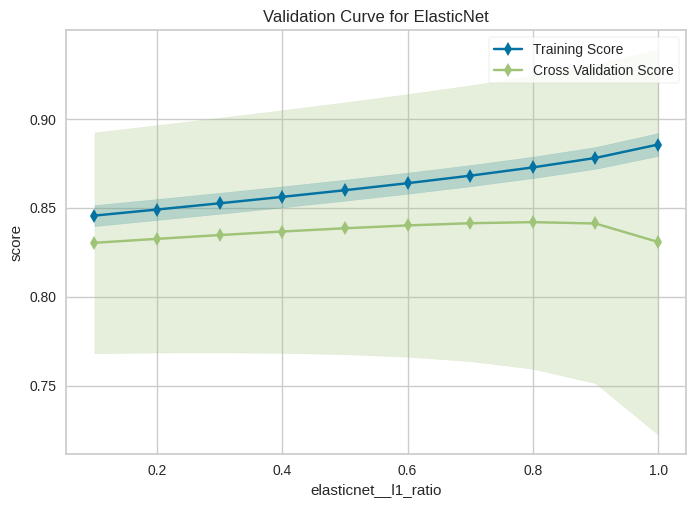

<AxesSubplot: title={'center': 'Validation Curve for ElasticNet'}, xlabel='elasticnet__l1_ratio', ylabel='score'>

In [17]:
pipe_validation = make_pipeline(
    std_scaler, OH_encoder, ElasticNet(alpha=1.099, max_iter=2000))
viz = ValidationCurve(
    pipe_validation, cv=10, param_name='elasticnet__l1_ratio', param_range=np.arange(0.1, 1.1, 0.1)
)
# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 15, 16, 17, 18, 23, 25, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 15, 16, 17, 18, 23, 25, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


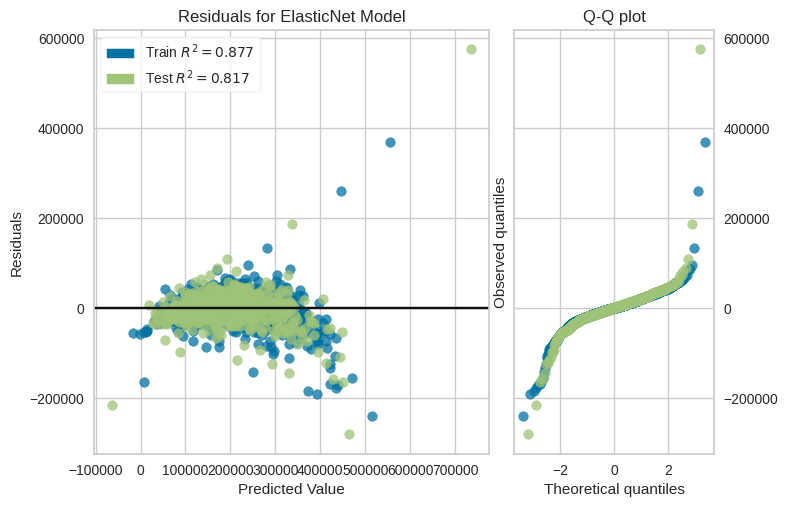

<AxesSubplot: title={'center': 'Residuals for ElasticNet Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [18]:
pipe_final = make_pipeline(std_scaler, OH_encoder, ElasticNet(
    l1_ratio=0.9, max_iter=2000, alpha=1.0))
visualizer = ResidualsPlot(pipe_final, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [19]:
importances = list(zip(pipe_final._final_estimator.feature_names_in_,
                   pipe_final._final_estimator.coef_))


In [20]:
sorted(importances, key=lambda x: abs(x[1]), reverse=True)


[('OverallQual', 13193.193744343022),
 ('GrLivArea', 10741.806137324824),
 ('MasVnrArea', 7722.290836727204),
 ('BsmtQual', 7474.322168834639),
 ('2ndFlrSF', 7324.0976350000665),
 ('MiscVal', -7191.101850773652),
 ('TotalBsmtSF', 6930.477186474624),
 ('KitchenQual', 6860.7464330615485),
 ('BldgType_infrequent_sklearn', -6713.044905048084),
 ('ExterQual', 6702.649754856211),
 ('BsmtFinSF1', 6421.958863014338),
 ('BsmtExposure_Gd', 6201.959980002869),
 ('1stFlrSF', 5935.593815980967),
 ('GarageArea', 4965.944151997388),
 ('SaleType_infrequent_sklearn', 4656.55852911103),
 ('OverallCond', 4051.825860638719),
 ('Fireplaces', 3740.28523406794),
 ('BsmtExposure_No', -3720.8778758122503),
 ('MasVnrType_BrkFace', -3513.2314145974638),
 ('LotArea', 3397.6511782022985),
 ('BsmtExposure_infrequent_sklearn', -3396.0213627620687),
 ('Condition1_infrequent_sklearn', -3392.660716287796),
 ('MSSubClass_infrequent_sklearn', -3299.685109497192),
 ('TotRmsAbvGrd', 3236.767080645333),
 ('GarageFinish_RFn'

In [21]:
rmse_test = mean_squared_error(
    pipe_final.predict(X_test), y_test, squared=False)
print(f"rmse = {rmse_test}")


rmse = 34169.86593448573


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 15, 16, 17, 18, 23, 25, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [22]:
save_score(gs.best_params_, rmse_test)
